In [17]:
%matplotlib inline

In [2]:
from hyperseti.data_array import from_h5, from_fil
from hyperseti.plotting import imshow_waterfall
from hyperseti import dedoppler, normalize
from hyperseti.peak import prominent_peaks
from hyperseti.utils import on_gpu, datwrapper
from hyperseti.data_array import DataArray, DimensionScale, TimeScale

import cupy as cp
import numpy as np
import pylab as plt
import time
import pandas as pd
import logging

import dask.bag as db
from dask.diagnostics import ProgressBar

from astropy import units as u
import setigen as stg
import matplotlib.pyplot as plt

from cupyimg.skimage.feature import peak_local_max
from cupyx.scipy.ndimage import uniform_filter1d

import hdf5plugin
import h5py
from copy import deepcopy
import pyfof
import hyperseti

bshuf filter already loaded, skip it.


### Generate test data

,f_start,drift_rate,snr,width
0,6.095205e+09,0.7 Hz / s,100,20.0 Hz
1,6.095205e+09,-0.55 Hz / s,100,20.0 Hz
2,6.095209e+09,0.0 Hz / s,40,6.0 Hz
3,6.095212e+09,0.07 Hz / s,50,3.0 Hz


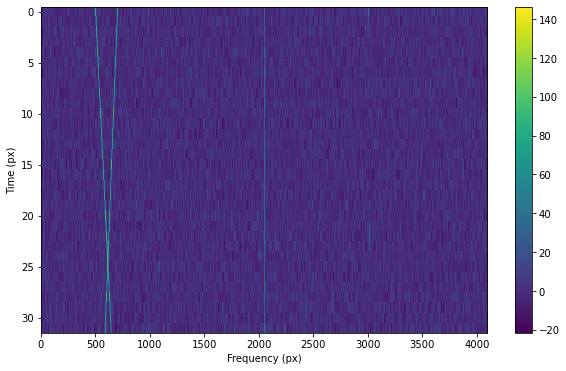

In [18]:
metadata = {'fch1': 6095.214842353016*u.MHz, 
            'dt': 18.25361108*u.s, 
            'df': 2.7939677238464355*u.Hz}

frame = stg.Frame(fchans=2**12*u.pixel,
                  tchans=32*u.pixel,
                  df=metadata['df'],
                  dt=metadata['dt'],
                  fch1=metadata['fch1'])

test_tones = [
  {'f_start': frame.get_frequency(index=500), 'drift_rate': 0.70*u.Hz/u.s, 'snr': 100, 'width': 20*u.Hz},
  {'f_start': frame.get_frequency(index=700), 'drift_rate': -0.55*u.Hz/u.s, 'snr': 100, 'width': 20*u.Hz},
  {'f_start': frame.get_frequency(index=2048), 'drift_rate': 0.00*u.Hz/u.s, 'snr': 40, 'width': 6*u.Hz},
  {'f_start': frame.get_frequency(index=3000), 'drift_rate': 0.07*u.Hz/u.s, 'snr': 50, 'width': 3*u.Hz}
]

noise = frame.add_noise(x_mean=0, x_std=5, noise_type='gaussian')

for tone in test_tones:
    signal = frame.add_signal(stg.constant_path(f_start=tone['f_start'],
                                            drift_rate=tone['drift_rate']),
                          stg.constant_t_profile(level=frame.get_intensity(snr=tone['snr'])),
                          stg.gaussian_f_profile(width=tone['width']),
                          stg.constant_bp_profile(level=1))

fig = plt.figure(figsize=(10, 6))
frame.render()

pd.DataFrame(test_tones)

## Generate metadata for hyperseti and plot dedoppler

In [4]:
data = np.expand_dims(frame.data, axis=1)
data = normalize(data.astype('float32'))
data.shape

metadata = {'frequency_start': 6095.214842353016*u.MHz, 
            'time_start': 0 *u.s,
            'time_step': 18.25361108*u.s, 
            'frequency_step': 2.7939677238464355*u.Hz}

dims=('time', 'feed_id', 'frequency')

scales = {
        'time':      TimeScale('time', metadata['time_start'], metadata['time_step'], 
                     data.shape[0], time_format='unix', time_delta_format='sec'),
        'feed_id':   DimensionScale('feed_id', 0, 0, data.shape[1], units=''),
        'frequency': DimensionScale('frequency', metadata['frequency_start'], metadata['frequency_step'].to('MHz'), data.shape[2], units='MHz')
}

d_gpu = cp.array(data)

data_array = DataArray(data, dims, scales, attrs={}, units='counts')

dd, _md = dedoppler(data_array, max_dd=1.0, return_space='cpu')
hyperseti.plotting.imshow_dedopp(dd)

In [5]:
data_array

<DataArray: shape=(32, 1, 4096), dims=('time', 'feed_id', 'frequency')>

In [6]:
dd

<DataArray: shape=(419, 1, 4096), dims=('drift_rate', 'feed_id', 'frequency')>

## Define friends of friends and iterative search algorithms

In [7]:
def find_peaks_fof(data, threshold=10, link_length=10):
    """ Find peaks in image using Friends of Friends algorithm
    
    Uses pyfof.friends_of_friends function
    
    Args:
        data (np.array): 2D Data array (suggest that you normalize first!)
        threshold (float): Data threshold (i.e. signal-to-noise if normalized)
        link_length (float): Linking length between cluster members
    
    """
    
    # Get indexes for 
    xi, yi = np.where(data > threshold)
    vals_xiyi = data[xi, yi]
    
    # PyFoF need (Nx2) array to search through
    # Also needs to be float64 (inefficient recast!)
    xiyi = np.array((xi, yi)).astype('float64').T
    
    # Run Friends of friends algorithm
    groups = pyfof.friends_of_friends(xiyi, link_length)
    
    # For each group, find max value
    centroids_x, centroids_y, centroids_val = [], [], []
    for g in groups:
        # g is a list of indexes of the xiyi array
        # find idx for maximal point in vals_xiyi
        # Note: this is index of and index! (xiyi are indexes of data)
        idx_xiyi      = np.argmax(vals_xiyi[g])
        idx_dmax  = g[idx_xiyi] 
        
        centroids_x.append(xi[idx_dmax])
        centroids_y.append(yi[idx_dmax])
        centroids_val.append(vals_xiyi[idx_dmax])
    return np.array(centroids_val), np.array(centroids_y), np.array(centroids_x)

def find_max_idx(data):
    """ Find array indexes and maximum value within an array
    
    GPU (cupy) version
    
    Args:
        data (cp.array): Data array
    
    Returngs:
        idx, v: array indexes (tuple) and maximum value v
    """
    idx = cp.unravel_index(cp.argmax(data), data.shape)
    v = data[idx]
    return idx, v

def blank_hit(data, metadata, f0, drate, padding=4):
    """ Blank a hit in an array by setting its value to zero
    
    Args:
        data (cp.array): Data array
        metadata (dict): Metadata with frequency, time info
        f0 (astropy.Quantity): Frequency at t=0
        drate (astropy.Quantity): Drift rate to blank
        padding (int): number of channels to blank either side. 
    
    Returns:
        data (cp.array): blanked data array
    
    TODO: Add check if drate * time_step > padding
    """
    n_time, n_pol, n_chans = data.shape
    i0     = int((f0 - metadata['frequency_start']) / metadata['frequency_step'])
    i_step =  metadata['time_step'] * drate / metadata['frequency_step']
    i_off  = (i_step * np.arange(n_time) + i0).astype('int64')
    
    min_padding = int(abs(i_step) + 1)  # i_step == frequency smearing
    padding += min_padding 
    i_time = np.arange(n_time, dtype='int64')
    for p_off in range(padding):
        data[i_time, :, i_off] = 0
        data[i_time, :, i_off - p_off] = 0
        data[i_time, :, i_off + p_off] = 0
    return data


@datwrapper()
@on_gpu
def find_hits_recursive(data, metadata, max_hits=100, threshold=20, padding=4):
    """ Find all hits in data, by recursively blanking top hit
    
    This method runs dedoppler multiple times, blanking the brightest hit
    each time then re-running, until max_hits is reached or no more hits
    above threshold are found.
    
    Note:
        max_hits is used to allocate hit arrays, so large values preallocate
        large amounts of memory. (TODO: This could be improved, dynamic resizing)
    
    Args:
        data (cp.array): Data array
        metadata (dict): Metadata with frequency, time info
        max_hits (int): Maximum number of hits
        threshold (float): S/N threshold
        padding (int): Padding to apply when blanking hit -- see blank_hit()
    
    Returns:
        hv, hf, hdr (tuple of cp.array): Values, freq idx, drift rate index arrays. 
    """
    data = normalize(data.astype('float32'), return_space='gpu')

    hit_id = 0
    
    hf = cp.asarray(np.zeros(shape=(max_hits)), dtype='int64')
    hdr = cp.asarray(np.zeros(shape=(max_hits)), dtype='int64')
    hv = cp.asarray(np.zeros(shape=(max_hits)), dtype='float32')
    
    while hit_id < max_hits:
        dd, _md = dedoppler(data, metadata, max_dd=1.0, return_space='gpu')
        idx, val = find_max_idx(dd.data)
        if val > threshold:
            
            f_idx  = int(idx[dd.dims.index('frequency')])
            dr_idx = int(idx[dd.dims.index('drift_rate')])
            hf[hit_id] = f_idx
            hdr[hit_id] = dr_idx
            hv[hit_id] = val
            f0     = dd.frequency[f_idx] * dd.frequency.units
            drate  = dd.drift_rate[dr_idx]  * dd.drift_rate.units
            data = blank_hit(data, metadata, f0, drate, padding=padding)
            hit_id += 1
        else:
            break
    return hv[:hit_id], hf[:hit_id], hdr[:hit_id]

In [8]:
hits_rx  = find_hits_recursive(data_array, threshold=30, max_hits=8, padding=4, return_space='cpu')
hits_rx

[array([426.25037, 383.26047, 167.91064, 140.21107], dtype=float32),
 array([ 700,  501, 2048, 3001]),
 array([ 93, 354, 208, 223])]

In [23]:
metadata = {'frequency_start': 6095.214842353016*u.MHz, 
            'time_start': 0 *u.s,
            'time_step': 18.25361108*u.s, 
            'frequency_step': 2.7939677238464355*u.Hz}

hits_rx  = find_hits_recursive(d_gpu, metadata, threshold=30, max_hits=8, padding=4, return_space='cpu')
hits_rx

[array([426.25037, 383.26047, 167.91064, 140.21107], dtype=float32),
 array([ 700,  501, 2048, 3001]),
 array([ 93, 354, 208, 223])]

In [11]:
dd, _md = dedoppler(data, metadata, max_dd=1.0, return_space='cpu')

hits_fof = find_peaks_fof(dd.data.squeeze(), threshold=30, link_length=30)
hits_pp  = prominent_peaks(cp.asarray(dd.data.squeeze()), threshold=30, min_xdistance=50, min_ydistance=50)
hits_rx  = find_hits_recursive(d_gpu, metadata, threshold=30, max_hits=8, padding=4, return_space='cpu')

In [12]:
print(hits_fof)
print(hits_pp)
print(hits_rx)

(array([426.25037 , 167.91064 , 140.21107 ,  31.219767], dtype=float32), array([ 700, 2048, 3001,  699]), array([ 93, 209, 223, 264]))
(array([426.25037, 419.86978, 167.91064, 140.21107], dtype=float32), array([ 700,  500, 2048, 3001]), array([ 93, 356, 210, 223]))
[array([426.25037, 383.26047, 167.91064, 140.21107], dtype=float32), array([ 700,  501, 2048, 3001]), array([ 93, 354, 208, 223])]


In [13]:
%timeit find_peaks_fof(dd.data.squeeze(), threshold=30, link_length=50)
%timeit prominent_peaks(cp.asarray(dd.data.squeeze()), threshold=30, min_xdistance=50, min_ydistance=50)
%timeit find_hits_recursive(d_gpu, metadata, threshold=30, max_hits=8)

58.2 ms ± 937 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.5 ms ± 31.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
43.4 ms ± 4.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### Plot data

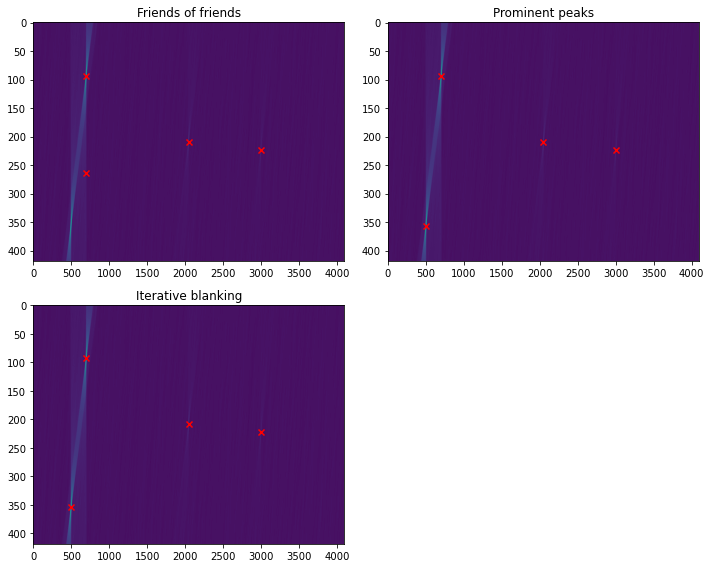

In [19]:
plt.figure(figsize=(10, 8))
plt.subplot(2,2,1)
plt.imshow(dd.data.squeeze(), aspect='auto')
plt.scatter(hits_fof[1], hits_fof[2], marker='x', color='red')
plt.title("Friends of friends")

plt.subplot(2,2,2)
plt.imshow(dd.data.squeeze(), aspect='auto')
plt.scatter(cp.asnumpy(hits_pp[1]), cp.asnumpy(hits_pp[2]), marker='x', color='red')
plt.title("Prominent peaks")

plt.subplot(2,2,3)
plt.imshow(dd.data.squeeze(), aspect='auto')
plt.scatter(cp.asnumpy(hits_rx[1]), cp.asnumpy(hits_rx[2]), marker='x', color='red')
plt.title("Iterative blanking")
plt.tight_layout()

In this instance, FoF misses a hit as it groups the two overlapping dedoppler butterflies as if one single hit

### Iterative blanking example

Run blank_hit five times, blanking top hit, and plotting after each blanked signal

In [21]:
metadata

{'fch1': <Quantity 6095.21484235 MHz>,
 'dt': <Quantity 18.25361108 s>,
 'df': <Quantity 2.79396772 Hz>}

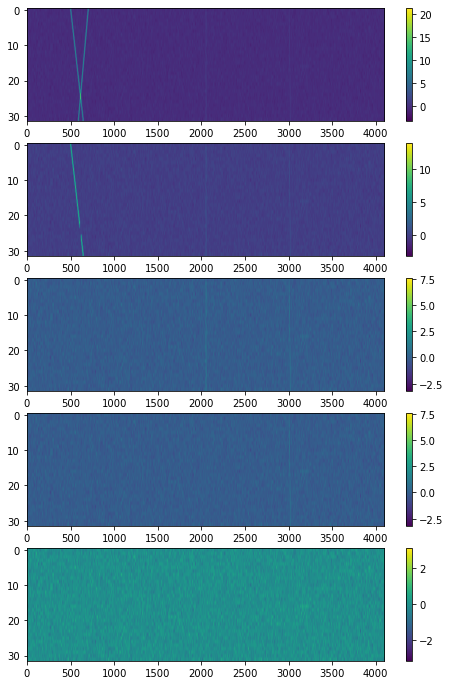

In [24]:
metadata = {'frequency_start': 6095.214842353016*u.MHz, 
            'time_start': 0 *u.s,
            'time_step': 18.25361108*u.s, 
            'frequency_step': 2.7939677238464355*u.Hz}

data = np.copy(np.expand_dims(frame.data, axis=1))
data = normalize(data.astype('float32'), return_space='cpu')

def find_max_idx_cpu(data):
    idx = np.unravel_index(np.argmax(data), data.shape)
    v = data[idx]
    return v, idx


hits = []

plt.figure(figsize=(8, 12))
plt.subplot(5,1,1)
plt.imshow(data.squeeze(), aspect='auto')
plt.colorbar()

plt.subplot(5,1,2)
dd, _md = dedoppler(data, metadata, max_dd=1.0, return_space='cpu')
v, (x, y) = find_max_idx_cpu(dd.data.squeeze())
hits.append((x, y, v))
data = blank_hit(data, metadata, 
                 dd.frequency[y] * dd.frequency.units, dd.drift_rate[x] * dd.drift_rate.units, padding=8)
plt.imshow(data.squeeze(), aspect='auto')
plt.colorbar()

plt.subplot(5,1,3)
dd, _md = dedoppler(data, metadata, max_dd=1.0, return_space='cpu')
v, (x, y) = find_max_idx_cpu(dd.data.squeeze())
hits.append((x, y, v))
data = blank_hit(data, metadata, 
                 dd.frequency[y] * dd.frequency.units, dd.drift_rate[x] * dd.drift_rate.units, padding=8)
plt.imshow(data.squeeze(), aspect='auto')
plt.colorbar()

plt.subplot(5,1,4)
dd, _md = dedoppler(data, metadata, max_dd=1.0, return_space='cpu')
v, (x, y) = find_max_idx_cpu(dd.data.squeeze())
hits.append((x, y, v))
data = blank_hit(data, metadata, 
                 dd.frequency[y] * dd.frequency.units, dd.drift_rate[x] * dd.drift_rate.units, padding=8)
plt.imshow(data.squeeze(), aspect='auto')
plt.colorbar()

plt.subplot(5,1,5)
dd, _md = dedoppler(data, metadata, max_dd=1.0, return_space='cpu')
v, (x, y) = find_max_idx_cpu(dd.data.squeeze())
hits.append((x, y, v))
data = blank_hit(data, metadata, 
                 dd.frequency[y] * dd.frequency.units, dd.drift_rate[x] * dd.drift_rate.units, padding=8)
plt.imshow(data.squeeze(), aspect='auto')
plt.colorbar()